# Variational Autoencoders

In [1]:
#Imports 
import sys
sys.path.append("../../") 
from sklearn.metrics import (
    confusion_matrix, roc_curve)
from model.predict import *
from model.helpers import *
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [2]:
#load data 
TRAIN = {}
TEST = {}
VALIDATION = {}

path = "../../../data/interim/"
train = "train_"
test = "test_"
validation = "validation_"
#  list of scenarios
scenarios = [
        'CVE-2012-2122',
        'CVE-2014-0160',
        'CVE-2017-7529',
        'CVE-2017-12635_6',
        'CVE-2018-3760',
        'CVE-2019-5418',
        'CVE-2020-9484',
        'CVE-2020-13942',
        'CVE-2020-23839',
        'CWE-89-SQL-injection'
]

for i in range(0,len(scenarios)):
    TRAIN[scenarios[i]]= pd.read_pickle(path + "/" + train + scenarios[i] + ".pkl")
    TEST[scenarios[i]] = pd.read_pickle(path + "/" + test + scenarios[i] + ".pkl")
    VALIDATION[scenarios[i]] = pd.read_pickle(path + "/" + validation + scenarios[i] + ".pkl")
            

In [3]:
models = {}
for i in range(0,len(scenarios)):
    models[scenarios[i]] = load_model(model_type='VariationalAutoencoder', train_data=TRAIN, test_data=TEST, scenario=scenarios[i], contamination_rate=False)

2022-12-06 20:53:28.146882: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


298/298 [==============================] - 0s 365us/step


In [4]:
# get preditions
results = {}
for i in range(0, len(scenarios)):
    _, _, results[scenarios[i]] = predict_(models[scenarios[i]], model_type='VariationalAutoencoder', data=TEST, scenario=scenarios[i])
# remember 1 outliers, 0 inliners

1207/1207 [==============================] - 0s 359us/step


In [5]:
results['CVE-2012-2122']['VariationalAutoencoder_predictions'].value_counts()

1    87157
0    42123
Name: VariationalAutoencoder_predictions, dtype: int64

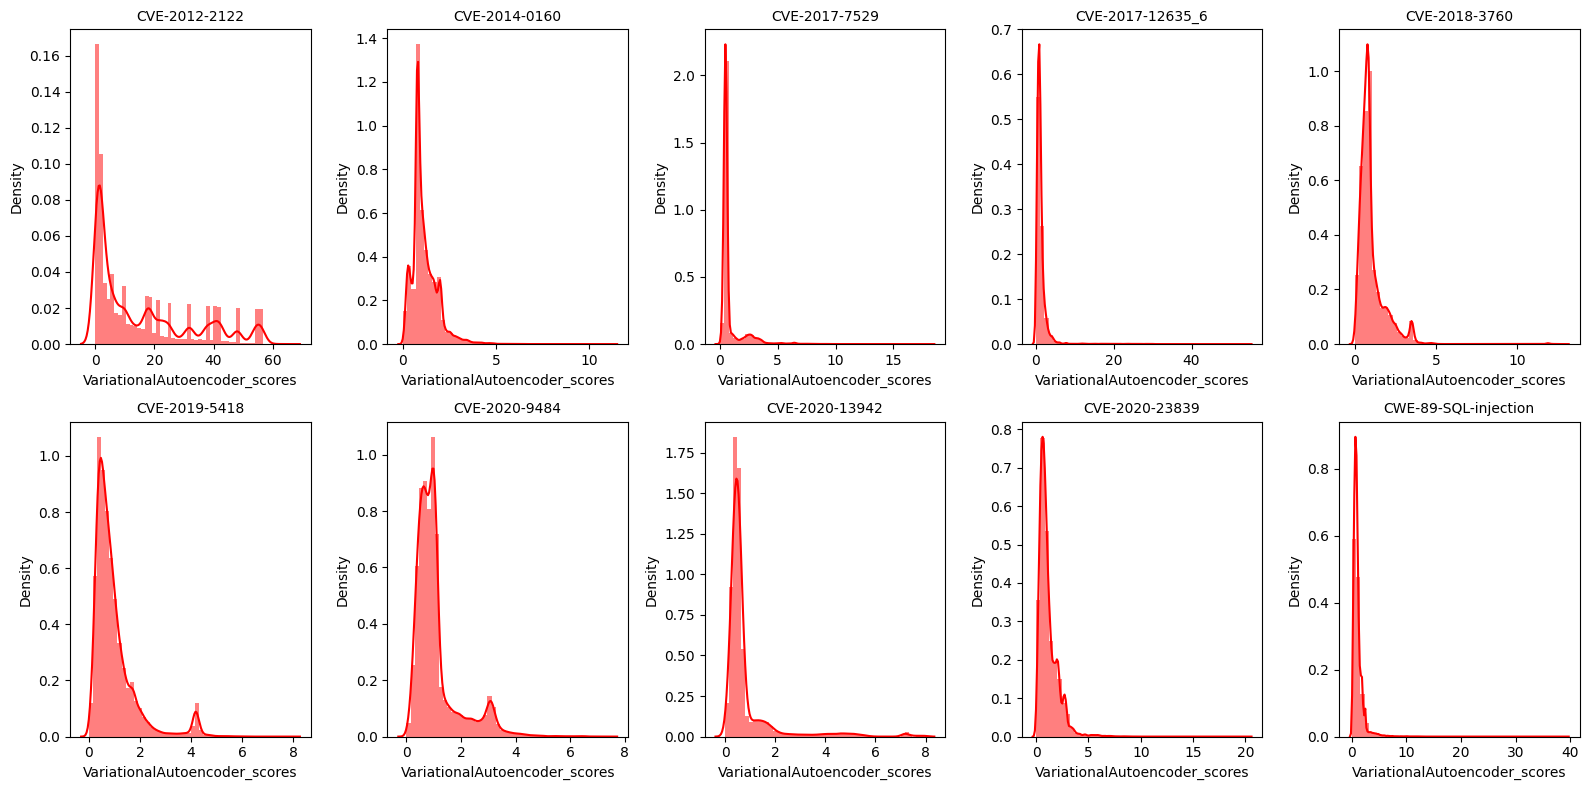

In [6]:
# Scores represent the shifted opposite of the Local Outlier Factor of X.
#Bigger is better, i.e. large values correspond to inliers.

# Distribution of Scores in each scenario 
fig, axes = plt.subplots(2,5, sharex=False, figsize=(16,8))
sns.distplot(results['CVE-2012-2122']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[0,0])
axes[0,0].set_title('CVE-2012-2122', fontsize = 10, loc='center')

sns.distplot(results['CVE-2014-0160']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[0,1])
axes[0,1].set_title('CVE-2014-0160', fontsize = 10, loc='center')

sns.distplot(results['CVE-2017-7529']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[0,2])
axes[0,2].set_title('CVE-2017-7529', fontsize = 10, loc='center')

sns.distplot(results['CVE-2017-12635_6']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[0,3])
axes[0,3].set_title('CVE-2017-12635_6', fontsize = 10, loc='center')

sns.distplot(results['CVE-2018-3760']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[0,4])
axes[0,4].set_title('CVE-2018-3760', fontsize = 10, loc='center')

sns.distplot(results['CVE-2019-5418']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[1,0])
axes[1,0].set_title('CVE-2019-5418', fontsize = 10, loc='center')

sns.distplot(results['CVE-2020-9484']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[1,1])
axes[1,1].set_title('CVE-2020-9484', fontsize = 10, loc='center')

sns.distplot(results['CVE-2020-13942']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[1,2])
axes[1,2].set_title('CVE-2020-13942', fontsize = 10, loc='center')

sns.distplot(results['CVE-2020-23839']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[1,3])
axes[1,3].set_title('CVE-2020-23839', fontsize = 10, loc='center')

sns.distplot(results['CWE-89-SQL-injection']['VariationalAutoencoder_scores'],color='red',label='if',hist_kws = {"alpha": 0.5}, ax=axes[1,4])
axes[1,4].set_title('CWE-89-SQL-injection', fontsize = 10, loc='center')
fig.tight_layout()
plt.show()
fig.savefig("../../../src/plots/models/VAE_Scoresdisplot.png")

In [7]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(TEST[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers


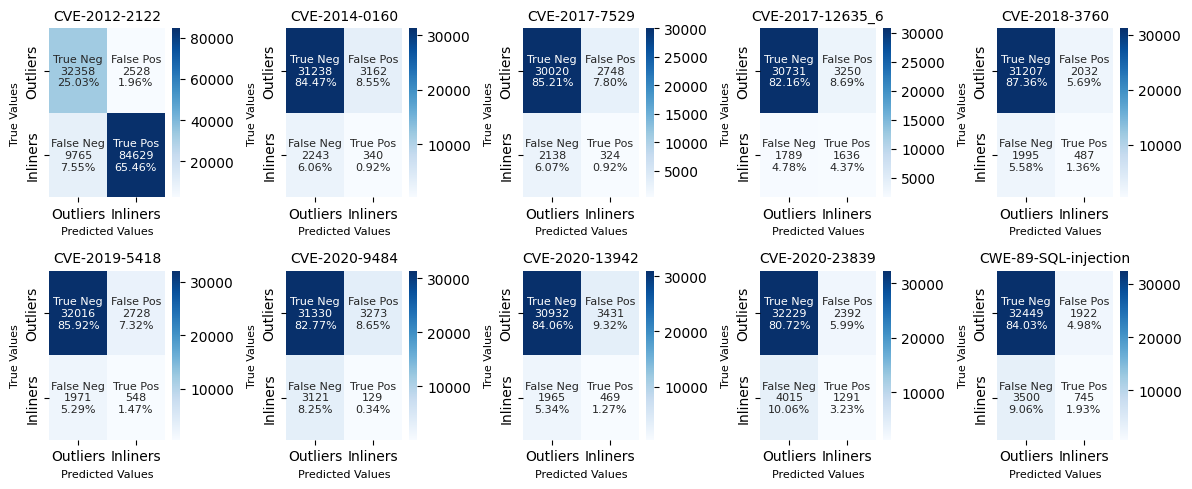

In [8]:
# True Negative: Top Left
# False Postive: Top Right
# False Negative: Bottom Left
# True Positive: Bottom Right

# Confusion Matrices
cms = {}
for key in results.keys():
    C = confusion_matrix(y_true=y_true[key], y_pred=results[key]['VariationalAutoencoder_predictions'])
    # dictionary with scenario name as key and confusion matrix as value
    dict_ = {key:C}
    cms.update(dict_)

fig, axes = plt.subplots(2,5, figsize=(12,5))
# CVE-2012-2122
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2012-2122'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2012-2122'].flatten()/np.sum(cms['CVE-2012-2122'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cms['CVE-2012-2122'], annot=labels,
            annot_kws={"fontsize":8},
            fmt='2', cmap='Blues',
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,0])
axes[0,0].set_title('CVE-2012-2122', size=10)
axes[0,0].set_xlabel('Predicted Values', size=8)
axes[0,0].set_ylabel('True Values', size=8)

#CVE-2014-0160
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2014-0160'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2014-0160'].flatten()/np.sum(cms['CVE-2014-0160'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2014-0160'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,1])
axes[0,1].set_title('CVE-2014-0160', size=10)
axes[0,1].set_xlabel('Predicted Values', size=8)
axes[0,1].set_ylabel('True Values', size=8)


#CVE-2017-7529
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-7529'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-7529'].flatten()/np.sum(cms['CVE-2017-7529'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-7529'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,2])
axes[0,2].set_title('CVE-2017-7529', size=10)
axes[0,2].set_xlabel('Predicted Values', size=8)
axes[0,2].set_ylabel('True Values', size=8)


#CVE-2017-12635_6
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-12635_6'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-12635_6'].flatten()/np.sum(cms['CVE-2017-12635_6'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-12635_6'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,3])
axes[0,3].set_title('CVE-2017-12635_6', size=10)
axes[0,3].set_xlabel('Predicted Values', size=8)
axes[0,3].set_ylabel('True Values', size=8)



#CVE-2018-3760
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2018-3760'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2018-3760'].flatten()/np.sum(cms['CVE-2018-3760'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2018-3760'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,4])
axes[0,4].set_title('CVE-2018-3760', size=10)
axes[0,4].set_xlabel('Predicted Values', size=8)
axes[0,4].set_ylabel('True Values', size=8)


#CVE-2019-5418
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2019-5418'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2019-5418'].flatten()/np.sum(cms['CVE-2019-5418'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2019-5418'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,0])
axes[1,0].set_title('CVE-2019-5418', size=10)
axes[1,0].set_xlabel('Predicted Values', size=8)
axes[1,0].set_ylabel('True Values', size=8)

#CVE-2020-9484
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-9484'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-9484'].flatten()/np.sum(cms['CVE-2020-9484'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-9484'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,1])
axes[1,1].set_title('CVE-2020-9484', size=10)
axes[1,1].set_xlabel('Predicted Values', size=8)
axes[1,1].set_ylabel('True Values', size=8)


#CVE-2020-13942
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-13942'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-13942'].flatten()/np.sum(cms['CVE-2020-13942'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-13942'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,2])
axes[1,2].set_title('CVE-2020-13942', size=10)
axes[1,2].set_xlabel('Predicted Values', size=8)
axes[1,2].set_ylabel('True Values', size=8)


#CVE-2020-23839
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-23839'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-23839'].flatten()/np.sum(cms['CVE-2020-23839'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-23839'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,3])
axes[1,3].set_title('CVE-2020-23839', size=10)
axes[1,3].set_xlabel('Predicted Values', size=8)
axes[1,3].set_ylabel('True Values', size=8)


#CWE-89-SQL-injection
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CWE-89-SQL-injection'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CWE-89-SQL-injection'].flatten()/np.sum(cms['CWE-89-SQL-injection'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CWE-89-SQL-injection'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,4])
axes[1,4].set_title('CWE-89-SQL-injection', size=10)
axes[1,4].set_xlabel('Predicted Values', size=8)
axes[1,4].set_ylabel('True Values', size=8)


fig.tight_layout()
plt.show()
fig.savefig("../../../src/plots/models/VAE_ConfusionMatrix_testdata.png")

In [9]:
# get rates to evaluate the results
pd.options.display.float_format = '{:.2f}'.format
data = {}
for key in cms.keys():
    true_negative = cms[key][0,0]
    false_positve = cms[key][0,1]
    false_negative = cms[key][1,0]
    true_positve = cms[key][1,1]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = true_positve/(true_positve+false_negative)
    # Specificity or true negative rate
    TNR = true_negative/(true_negative+false_positve) 
    # Precision or positive predictive value
    PPV = true_positve/(true_positve+false_positve)
    # Negative predictive value
    NPV = true_negative/(true_negative+false_negative)
    # Fall out or false positive rate
    FPR = false_positve/(false_positve+true_negative)
    # False negative rate
    FNR = false_negative/(true_positve+false_negative)
    # False discovery rate
    FDR = false_positve/(true_positve+false_positve)
    # Overall accuracy
    ACC = (true_positve+true_negative)/(true_positve+false_positve+false_negative+true_negative)
    
    # F1 Score
    F1 =  2 * (PPV * TPR) / (PPV + TPR)

    data[key] = {
        "FPR": FPR,
        "FNR": FNR,
        "Recall": TPR,
        "Precision": PPV,
        "ACC": ACC,
        "F1": F1

    }
# print dataframe
output = pd.DataFrame(data).transpose() 
# False Postive Rate (FPR) good because this means that only 7% of the anomalies detected were in fact, not anomalous at all.
# False Negative Rate (FNR) This means that the system missed only 15% of all anomalies in the data.
output.to_latex("../../../src/tables/VAE_Table_FPR_FNR_ACC_TEST.tex")

In [10]:
output

,FPR,FNR,Recall,Precision,ACC,F1
CVE-2012-2122,0.07,0.10,0.90,0.97,0.90,0.93
CVE-2014-0160,0.09,0.87,0.13,0.10,0.85,0.11
CVE-2017-7529,0.08,0.87,0.13,0.11,0.86,0.12
CVE-2017-12635_6,0.10,0.52,0.48,0.33,0.87,0.39
CVE-2018-3760,0.06,0.80,0.20,0.19,0.89,0.19
CVE-2019-5418,0.08,0.78,0.22,0.17,0.87,0.19
CVE-2020-9484,0.09,0.96,0.04,0.04,0.83,0.04
CVE-2020-13942,0.10,0.81,0.19,0.12,0.85,0.15
CVE-2020-23839,0.07,0.76,0.24,0.35,0.84,0.29
CWE-89-SQL-injection,0.06,0.82,0.18,0.28,0.86,0.22


### How does the Algorithm behave when there are no outliers?

We will perform outlier truncation on the test data only for the exploit == False observations

In [11]:
no_outliers = {}
for i in range(0,len(scenarios)):
    normal = TEST[scenarios[i]][TEST[scenarios[i]]['exploit']==False]
    attack = TEST[scenarios[i]][TEST[scenarios[i]]['exploit']!=False]
    # chose only cpu_usage and memory_usage
    normal = select_columns_outlier_truncate(normal)
    attack = select_columns_outlier_truncate(attack)
    # calculate IQR for each scenario
    Q1 = normal.quantile(0.25)
    Q3 = normal.quantile(0.75)
    IQR = Q3 - Q1
    normal = normal[~((normal< (Q1 - 1.5 * IQR)) |(normal > (Q3 + 1.5 * IQR))).any(axis=1)]
    no_outliers[scenarios[i]] = pd.concat([normal, attack])


In [12]:
# get all scenarios in one data set at the end
no_outliers_test = []
for key in no_outliers.keys():
    no_outliers[key]['scenario'] = key
    temp_df = no_outliers[key]
    no_outliers_test.append(temp_df)
no_outliers['ALL'] = pd.concat(no_outliers_test)

In [13]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(no_outliers[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers

In [14]:
# get preditions
results = {}
for i in range(0, len(scenarios)):
    _, _, results[scenarios[i]] = predict_(models[scenarios[i]], model_type='VariationalAutoencoder', data=no_outliers, scenario=scenarios[i])
# remember 1 outliers, 0 inliners

1141/1141 [==============================] - 0s 362us/step


In [15]:
results['CVE-2012-2122']

,cpu_usage,memory_usage,VariationalAutoencoder_predictions,VariationalAutoencoder_scores
timestamp,,,,
2021-09-13 16:11:26.915,0.04,84586496,0,1.76
2021-09-13 16:11:27.920,0.03,84815872,0,1.76
2021-09-13 16:11:28.925,0.01,84832256,0,2.08
2021-09-13 16:11:29.931,0.03,85037056,0,1.72
2021-09-13 16:11:30.936,0.05,85245952,0,1.52
...,...,...,...,...
2021-09-14 14:10:08.467,0.05,91000832,0,0.76
2021-09-14 14:10:09.474,0.04,91033600,0,0.73
2021-09-14 14:10:10.480,0.07,91176960,0,1.06


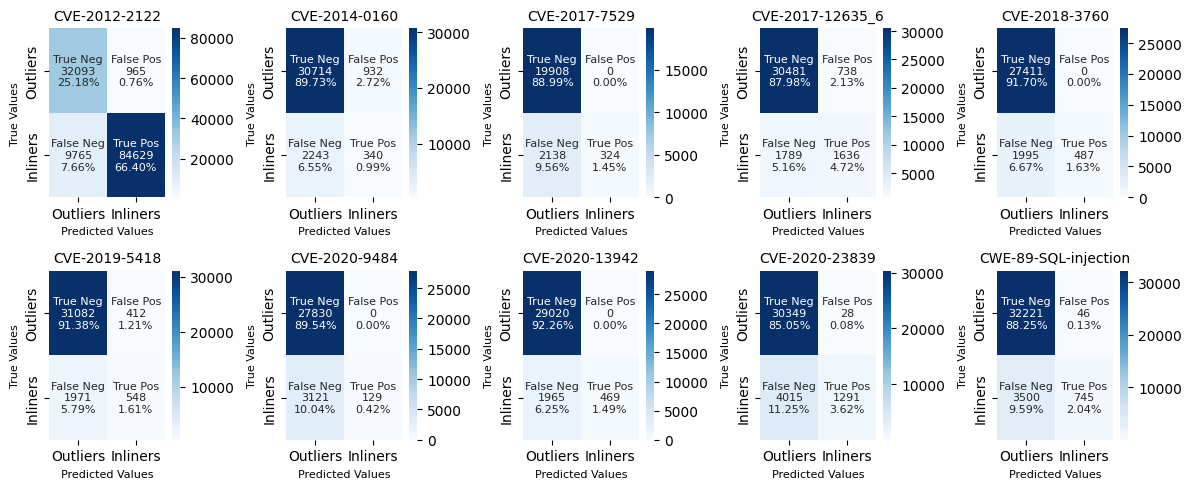

In [16]:
# True Negative: Top Left
# False Postive: Top Right
# False Negative: Bottom Left
# True Positive: Bottom Right

# Confusion Matrices
cms = {}
for key in results.keys():
    C = confusion_matrix(y_true=y_true[key], y_pred=results[key]['VariationalAutoencoder_predictions'])
    # dictionary with scenario name as key and confusion matrix as value
    dict_ = {key:C}
    cms.update(dict_)

fig, axes = plt.subplots(2,5, figsize=(12,5))
# CVE-2012-2122
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2012-2122'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2012-2122'].flatten()/np.sum(cms['CVE-2012-2122'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cms['CVE-2012-2122'], annot=labels,
            annot_kws={"fontsize":8},
            fmt='2', cmap='Blues',
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,0])
axes[0,0].set_title('CVE-2012-2122', size=10)
axes[0,0].set_xlabel('Predicted Values', size=8)
axes[0,0].set_ylabel('True Values', size=8)

#CVE-2014-0160
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2014-0160'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2014-0160'].flatten()/np.sum(cms['CVE-2014-0160'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2014-0160'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,1])
axes[0,1].set_title('CVE-2014-0160', size=10)
axes[0,1].set_xlabel('Predicted Values', size=8)
axes[0,1].set_ylabel('True Values', size=8)


#CVE-2017-7529
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-7529'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-7529'].flatten()/np.sum(cms['CVE-2017-7529'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-7529'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,2])
axes[0,2].set_title('CVE-2017-7529', size=10)
axes[0,2].set_xlabel('Predicted Values', size=8)
axes[0,2].set_ylabel('True Values', size=8)


#CVE-2017-12635_6
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-12635_6'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-12635_6'].flatten()/np.sum(cms['CVE-2017-12635_6'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-12635_6'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,3])
axes[0,3].set_title('CVE-2017-12635_6', size=10)
axes[0,3].set_xlabel('Predicted Values', size=8)
axes[0,3].set_ylabel('True Values', size=8)



#CVE-2018-3760
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2018-3760'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2018-3760'].flatten()/np.sum(cms['CVE-2018-3760'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2018-3760'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,4])
axes[0,4].set_title('CVE-2018-3760', size=10)
axes[0,4].set_xlabel('Predicted Values', size=8)
axes[0,4].set_ylabel('True Values', size=8)


#CVE-2019-5418
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2019-5418'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2019-5418'].flatten()/np.sum(cms['CVE-2019-5418'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2019-5418'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,0])
axes[1,0].set_title('CVE-2019-5418', size=10)
axes[1,0].set_xlabel('Predicted Values', size=8)
axes[1,0].set_ylabel('True Values', size=8)

#CVE-2020-9484
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-9484'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-9484'].flatten()/np.sum(cms['CVE-2020-9484'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-9484'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,1])
axes[1,1].set_title('CVE-2020-9484', size=10)
axes[1,1].set_xlabel('Predicted Values', size=8)
axes[1,1].set_ylabel('True Values', size=8)


#CVE-2020-13942
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-13942'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-13942'].flatten()/np.sum(cms['CVE-2020-13942'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-13942'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,2])
axes[1,2].set_title('CVE-2020-13942', size=10)
axes[1,2].set_xlabel('Predicted Values', size=8)
axes[1,2].set_ylabel('True Values', size=8)


#CVE-2020-23839
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-23839'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-23839'].flatten()/np.sum(cms['CVE-2020-23839'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-23839'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,3])
axes[1,3].set_title('CVE-2020-23839', size=10)
axes[1,3].set_xlabel('Predicted Values', size=8)
axes[1,3].set_ylabel('True Values', size=8)


#CWE-89-SQL-injection
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CWE-89-SQL-injection'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CWE-89-SQL-injection'].flatten()/np.sum(cms['CWE-89-SQL-injection'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CWE-89-SQL-injection'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,4])
axes[1,4].set_title('CWE-89-SQL-injection', size=10)
axes[1,4].set_xlabel('Predicted Values', size=8)
axes[1,4].set_ylabel('True Values', size=8)


fig.tight_layout()
plt.show()
fig.savefig("../../../src/plots/models/VAE_ConfusionMatrix_no_outliers_testdata.png")

In [17]:
# get rates to evaluate the results
pd.options.display.float_format = '{:.2f}'.format
data = {}
for key in cms.keys():
    true_negative = cms[key][0,0]
    false_positve = cms[key][0,1]
    false_negative = cms[key][1,0]
    true_positve = cms[key][1,1]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = true_positve/(true_positve+false_negative)
    # Specificity or true negative rate
    TNR = true_negative/(true_negative+false_positve) 
    # Precision or positive predictive value
    PPV = true_positve/(true_positve+false_positve)
    # Negative predictive value
    NPV = true_negative/(true_negative+false_negative)
    # Fall out or false positive rate
    FPR = false_positve/(false_positve+true_negative)
    # False negative rate
    FNR = false_negative/(true_positve+false_negative)
    # False discovery rate
    FDR = false_positve/(true_positve+false_positve)
    # Overall accuracy
    ACC = (true_positve+true_negative)/(true_positve+false_positve+false_negative+true_negative)
    # F1 Score
    F1 =  2 * (PPV * TPR) / (PPV + TPR)

    data[key] = {
        "FPR": FPR,
        "FNR": FNR,
        "Recall": TPR,
        "Precision": PPV,
        "ACC": ACC,
        "F1": F1

    }
# print dataframe
output = pd.DataFrame(data).transpose() 
# False Postive Rate (FPR) good because this means that only 7% of the anomalies detected were in fact, not anomalous at all.
# False Negative Rate (FNR) This means that the system missed only 15% of all anomalies in the data.
output.to_latex("../../../src/tables/VAE_Table_FPR_FNR_ACC_TEST_no_outliers.tex")

In [18]:
output

,FPR,FNR,Recall,Precision,ACC,F1
CVE-2012-2122,0.03,0.10,0.90,0.99,0.92,0.94
CVE-2014-0160,0.03,0.87,0.13,0.27,0.91,0.18
CVE-2017-7529,0.00,0.87,0.13,1.00,0.90,0.23
CVE-2017-12635_6,0.02,0.52,0.48,0.69,0.93,0.56
CVE-2018-3760,0.00,0.80,0.20,1.00,0.93,0.33
CVE-2019-5418,0.01,0.78,0.22,0.57,0.93,0.32
CVE-2020-9484,0.00,0.96,0.04,1.00,0.90,0.08
CVE-2020-13942,0.00,0.81,0.19,1.00,0.94,0.32
CVE-2020-23839,0.00,0.76,0.24,0.98,0.89,0.39
CWE-89-SQL-injection,0.00,0.82,0.18,0.94,0.90,0.30


### Evaluation after Threshold Adjustment

In [19]:
thresholds_ = {}
for i in range(0, len(scenarios)):
    # prepare test data 
    X_test = no_outliers[scenarios[i]]
    X_test = select_columns_for_modelling(X_test)
    scores = models[scenarios[i]].decision_function(X_test)
    fpr_test_, tpr_test_, thresholds = roc_curve(y_true[scenarios[i]], scores)  
    J = tpr_test_ - fpr_test_
    ix = np.argmax(J)
    best_thresh = thresholds[ix]
    thresholds_[scenarios[i]] = best_thresh

1141/1141 [==============================] - 0s 366us/step


In [20]:
thresholds_

{'CVE-2012-2122': 2.4474360380927336,
 'CVE-2014-0160': 1.6231598729786665,
 'CVE-2017-7529': 0.5222099484331204,
 'CVE-2017-12635_6': 1.3916356513372994,
 'CVE-2018-3760': 1.181081481617291,
 'CVE-2019-5418': 2.1259179591204043,
 'CVE-2020-9484': 1.0005574232423224,
 'CVE-2020-13942': 0.8530836724172383,
 'CVE-2020-23839': 1.416772847372949,
 'CWE-89-SQL-injection': 1.4713395063367314}

In [21]:
for key in thresholds_.keys():
    results[key].loc[(results[key]['VariationalAutoencoder_scores']>thresholds_[key]), 'VariationalAutoencoder_predictions']=1

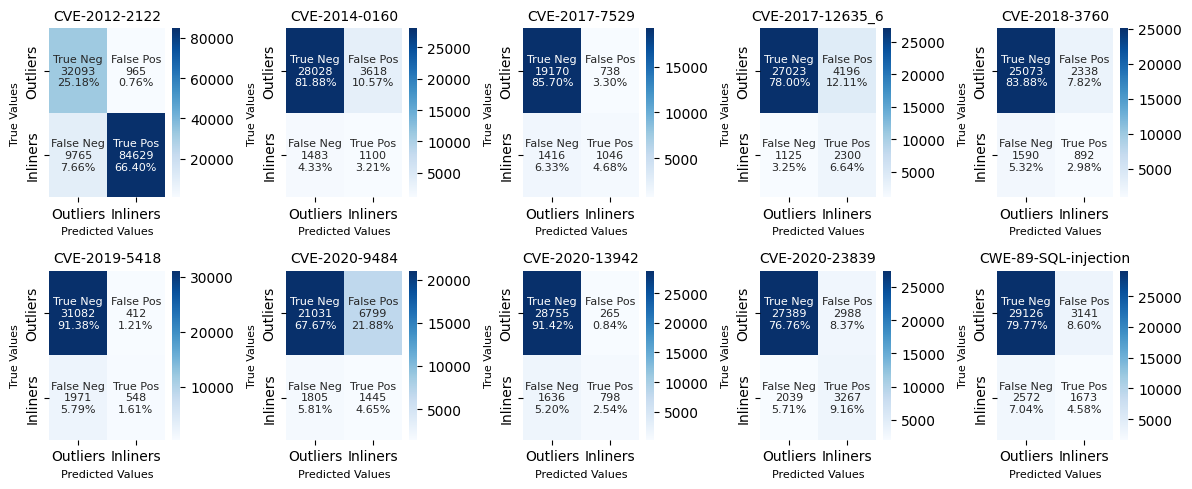

In [22]:
# True Negative: Top Left
# False Postive: Top Right
# False Negative: Bottom Left
# True Positive: Bottom Right

# Confusion Matrices
cms = {}
for key in results.keys():
    C = confusion_matrix(y_true=y_true[key], y_pred=results[key]['VariationalAutoencoder_predictions'])
    # dictionary with scenario name as key and confusion matrix as value
    dict_ = {key:C}
    cms.update(dict_)

fig, axes = plt.subplots(2,5, figsize=(12,5))
# CVE-2012-2122
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2012-2122'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2012-2122'].flatten()/np.sum(cms['CVE-2012-2122'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cms['CVE-2012-2122'], annot=labels,
            annot_kws={"fontsize":8},
            fmt='2', cmap='Blues',
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,0])
axes[0,0].set_title('CVE-2012-2122', size=10)
axes[0,0].set_xlabel('Predicted Values', size=8)
axes[0,0].set_ylabel('True Values', size=8)

#CVE-2014-0160
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2014-0160'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2014-0160'].flatten()/np.sum(cms['CVE-2014-0160'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2014-0160'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,1])
axes[0,1].set_title('CVE-2014-0160', size=10)
axes[0,1].set_xlabel('Predicted Values', size=8)
axes[0,1].set_ylabel('True Values', size=8)


#CVE-2017-7529
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-7529'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-7529'].flatten()/np.sum(cms['CVE-2017-7529'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-7529'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,2])
axes[0,2].set_title('CVE-2017-7529', size=10)
axes[0,2].set_xlabel('Predicted Values', size=8)
axes[0,2].set_ylabel('True Values', size=8)


#CVE-2017-12635_6
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-12635_6'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-12635_6'].flatten()/np.sum(cms['CVE-2017-12635_6'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-12635_6'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,3])
axes[0,3].set_title('CVE-2017-12635_6', size=10)
axes[0,3].set_xlabel('Predicted Values', size=8)
axes[0,3].set_ylabel('True Values', size=8)



#CVE-2018-3760
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2018-3760'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2018-3760'].flatten()/np.sum(cms['CVE-2018-3760'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2018-3760'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,4])
axes[0,4].set_title('CVE-2018-3760', size=10)
axes[0,4].set_xlabel('Predicted Values', size=8)
axes[0,4].set_ylabel('True Values', size=8)


#CVE-2019-5418
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2019-5418'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2019-5418'].flatten()/np.sum(cms['CVE-2019-5418'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2019-5418'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,0])
axes[1,0].set_title('CVE-2019-5418', size=10)
axes[1,0].set_xlabel('Predicted Values', size=8)
axes[1,0].set_ylabel('True Values', size=8)

#CVE-2020-9484
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-9484'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-9484'].flatten()/np.sum(cms['CVE-2020-9484'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-9484'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,1])
axes[1,1].set_title('CVE-2020-9484', size=10)
axes[1,1].set_xlabel('Predicted Values', size=8)
axes[1,1].set_ylabel('True Values', size=8)


#CVE-2020-13942
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-13942'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-13942'].flatten()/np.sum(cms['CVE-2020-13942'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-13942'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,2])
axes[1,2].set_title('CVE-2020-13942', size=10)
axes[1,2].set_xlabel('Predicted Values', size=8)
axes[1,2].set_ylabel('True Values', size=8)


#CVE-2020-23839
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-23839'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-23839'].flatten()/np.sum(cms['CVE-2020-23839'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-23839'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,3])
axes[1,3].set_title('CVE-2020-23839', size=10)
axes[1,3].set_xlabel('Predicted Values', size=8)
axes[1,3].set_ylabel('True Values', size=8)


#CWE-89-SQL-injection
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CWE-89-SQL-injection'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CWE-89-SQL-injection'].flatten()/np.sum(cms['CWE-89-SQL-injection'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CWE-89-SQL-injection'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,4])
axes[1,4].set_title('CWE-89-SQL-injection', size=10)
axes[1,4].set_xlabel('Predicted Values', size=8)
axes[1,4].set_ylabel('True Values', size=8)


fig.tight_layout()
plt.show()
fig.savefig("../../../src/plots/models/VAE_ConfusionMatrix_no_outliers_threshold_adjustment_testdata.png")

In [23]:
# get rates to evaluate the results
pd.options.display.float_format = '{:.2f}'.format
data = {}
for key in cms.keys():
    true_negative = cms[key][0,0]
    false_positve = cms[key][0,1]
    false_negative = cms[key][1,0]
    true_positve = cms[key][1,1]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = true_positve/(true_positve+false_negative)
    # Specificity or true negative rate
    TNR = true_negative/(true_negative+false_positve) 
    # Precision or positive predictive value
    PPV = true_positve/(true_positve+false_positve)
    # Negative predictive value
    NPV = true_negative/(true_negative+false_negative)
    # Fall out or false positive rate
    FPR = false_positve/(false_positve+true_negative)
    # False negative rate
    FNR = false_negative/(true_positve+false_negative)
    # False discovery rate
    FDR = false_positve/(true_positve+false_positve)
    # Overall accuracy
    ACC = (true_positve+true_negative)/(true_positve+false_positve+false_negative+true_negative)
    # F1 Score
    F1 =  2 * (PPV * TPR) / (PPV + TPR)

    data[key] = {
        "FPR": FPR,
        "FNR": FNR,
        "Recall": TPR,
        "Precision": PPV,
        "ACC": ACC,
        "F1": F1

    }
# print dataframe
output = pd.DataFrame(data).transpose() 
# False Postive Rate (FPR) good because this means that only 7% of the anomalies detected were in fact, not anomalous at all.
# False Negative Rate (FNR) This means that the system missed only 15% of all anomalies in the data.
output.to_latex("../../../src/tables/VAE_Table_FPR_FNR_ACC_TEST_no_outliers_threshold_adjustment.tex")

In [24]:
output

,FPR,FNR,Recall,Precision,ACC,F1
CVE-2012-2122,0.03,0.10,0.90,0.99,0.92,0.94
CVE-2014-0160,0.11,0.57,0.43,0.23,0.85,0.30
CVE-2017-7529,0.04,0.58,0.42,0.59,0.90,0.49
CVE-2017-12635_6,0.13,0.33,0.67,0.35,0.85,0.46
CVE-2018-3760,0.09,0.64,0.36,0.28,0.87,0.31
CVE-2019-5418,0.01,0.78,0.22,0.57,0.93,0.32
CVE-2020-9484,0.24,0.56,0.44,0.18,0.72,0.25
CVE-2020-13942,0.01,0.67,0.33,0.75,0.94,0.46
CVE-2020-23839,0.10,0.38,0.62,0.52,0.86,0.57
CWE-89-SQL-injection,0.10,0.61,0.39,0.35,0.84,0.37


## Results after adjusting the contamination rate dynamically

- Results with natural outliers
- Results no natural outliers

In [25]:
# load model 
models = {}
for i in range(0, len(scenarios)):
    # get dict and save mofel for each scenario
    models[scenarios[i]] = load_model(model_type='VariationalAutoencoder', train_data=TRAIN, test_data=TEST, scenario=scenarios[i], contamination_rate=True)

CVE-2012-2122:0.5
301/301 [==============================] - 1s 364us/step
CVE-2014-0160:0.07508720930232558
299/299 [==============================] - 0s 359us/step
CVE-2017-7529:0.07513427734375
296/296 [==============================] - 0s 355us/step
CVE-2017-12635_6:0.1007916188458256
294/294 [==============================] - 0s 359us/step
CVE-2018-3760:0.07467131983513343
296/296 [==============================] - 0s 354us/step
CVE-2019-5418:0.07250172691687773
300/300 [==============================] - 0s 354us/step
CVE-2020-9484:0.09392249226945641
300/300 [==============================] - 0s 402us/step
CVE-2020-13942:0.0708319995343829
300/300 [==============================] - 0s 353us/step
CVE-2020-23839:0.1532595823344213
299/299 [==============================] - 0s 357us/step
CWE-89-SQL-injection:0.1235052806144715
298/298 [==============================] - 0s 362us/step


In [26]:
# get preditions
results = {}
for i in range(0, len(scenarios)):
    _, _, results[scenarios[i]] = predict_(models[scenarios[i]], model_type='VariationalAutoencoder', data=TEST, scenario=scenarios[i])
# remember 1 outliers, 0 inliners

1207/1207 [==============================] - 1s 416us/step


In [27]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(TEST[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers

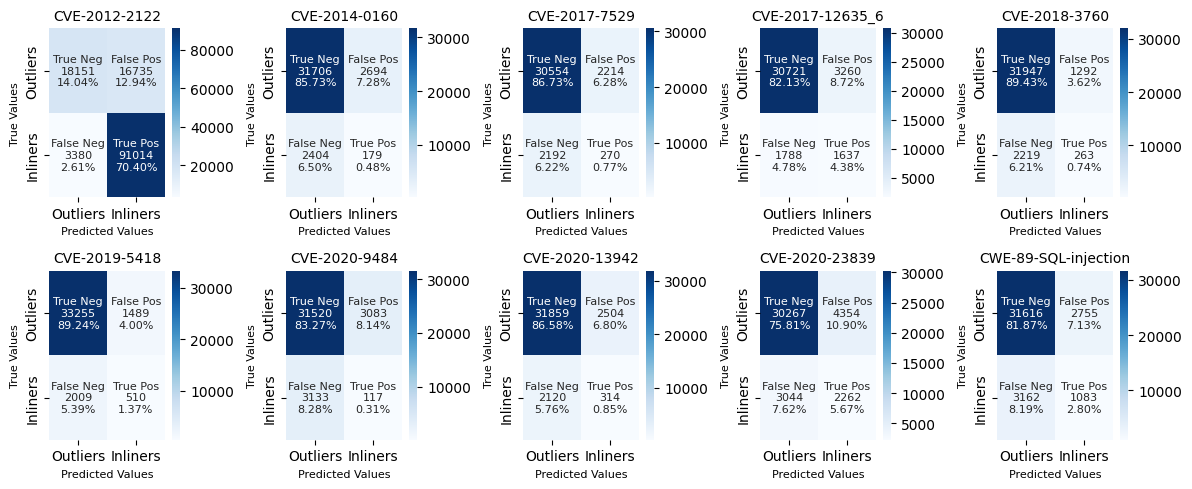

In [28]:
# True Negative: Top Left
# False Postive: Top Right
# False Negative: Bottom Left
# True Positive: Bottom Right

# Confusion Matrices
cms = {}
for key in results.keys():
    C = confusion_matrix(y_true=y_true[key], y_pred=results[key]['VariationalAutoencoder_predictions'])
    # dictionary with scenario name as key and confusion matrix as value
    dict_ = {key:C}
    cms.update(dict_)

fig, axes = plt.subplots(2,5, figsize=(12,5))
# CVE-2012-2122
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2012-2122'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2012-2122'].flatten()/np.sum(cms['CVE-2012-2122'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cms['CVE-2012-2122'], annot=labels,
            annot_kws={"fontsize":8},
            fmt='2', cmap='Blues',
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,0])
axes[0,0].set_title('CVE-2012-2122', size=10)
axes[0,0].set_xlabel('Predicted Values', size=8)
axes[0,0].set_ylabel('True Values', size=8)

#CVE-2014-0160
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2014-0160'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2014-0160'].flatten()/np.sum(cms['CVE-2014-0160'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2014-0160'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,1])
axes[0,1].set_title('CVE-2014-0160', size=10)
axes[0,1].set_xlabel('Predicted Values', size=8)
axes[0,1].set_ylabel('True Values', size=8)


#CVE-2017-7529
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-7529'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-7529'].flatten()/np.sum(cms['CVE-2017-7529'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-7529'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,2])
axes[0,2].set_title('CVE-2017-7529', size=10)
axes[0,2].set_xlabel('Predicted Values', size=8)
axes[0,2].set_ylabel('True Values', size=8)


#CVE-2017-12635_6
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-12635_6'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-12635_6'].flatten()/np.sum(cms['CVE-2017-12635_6'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-12635_6'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,3])
axes[0,3].set_title('CVE-2017-12635_6', size=10)
axes[0,3].set_xlabel('Predicted Values', size=8)
axes[0,3].set_ylabel('True Values', size=8)



#CVE-2018-3760
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2018-3760'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2018-3760'].flatten()/np.sum(cms['CVE-2018-3760'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2018-3760'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,4])
axes[0,4].set_title('CVE-2018-3760', size=10)
axes[0,4].set_xlabel('Predicted Values', size=8)
axes[0,4].set_ylabel('True Values', size=8)


#CVE-2019-5418
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2019-5418'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2019-5418'].flatten()/np.sum(cms['CVE-2019-5418'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2019-5418'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,0])
axes[1,0].set_title('CVE-2019-5418', size=10)
axes[1,0].set_xlabel('Predicted Values', size=8)
axes[1,0].set_ylabel('True Values', size=8)

#CVE-2020-9484
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-9484'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-9484'].flatten()/np.sum(cms['CVE-2020-9484'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-9484'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,1])
axes[1,1].set_title('CVE-2020-9484', size=10)
axes[1,1].set_xlabel('Predicted Values', size=8)
axes[1,1].set_ylabel('True Values', size=8)


#CVE-2020-13942
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-13942'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-13942'].flatten()/np.sum(cms['CVE-2020-13942'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-13942'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,2])
axes[1,2].set_title('CVE-2020-13942', size=10)
axes[1,2].set_xlabel('Predicted Values', size=8)
axes[1,2].set_ylabel('True Values', size=8)


#CVE-2020-23839
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-23839'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-23839'].flatten()/np.sum(cms['CVE-2020-23839'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-23839'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,3])
axes[1,3].set_title('CVE-2020-23839', size=10)
axes[1,3].set_xlabel('Predicted Values', size=8)
axes[1,3].set_ylabel('True Values', size=8)


#CWE-89-SQL-injection
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CWE-89-SQL-injection'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CWE-89-SQL-injection'].flatten()/np.sum(cms['CWE-89-SQL-injection'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CWE-89-SQL-injection'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,4])
axes[1,4].set_title('CWE-89-SQL-injection', size=10)
axes[1,4].set_xlabel('Predicted Values', size=8)
axes[1,4].set_ylabel('True Values', size=8)


fig.tight_layout()
plt.show()
fig.savefig("../../../src/plots/models/VAE_ConfusionMatrix_contamination_rate.png")

In [29]:
# get rates to evaluate the results
pd.options.display.float_format = '{:.2f}'.format
data = {}
for key in cms.keys():
    true_negative = cms[key][0,0]
    false_positve = cms[key][0,1]
    false_negative = cms[key][1,0]
    true_positve = cms[key][1,1]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = true_positve/(true_positve+false_negative)
    # Specificity or true negative rate
    TNR = true_negative/(true_negative+false_positve) 
    # Precision or positive predictive value
    PPV = true_positve/(true_positve+false_positve)
    # Negative predictive value
    NPV = true_negative/(true_negative+false_negative)
    # Fall out or false positive rate
    FPR = false_positve/(false_positve+true_negative)
    # False negative rate
    FNR = false_negative/(true_positve+false_negative)
    # False discovery rate
    FDR = false_positve/(true_positve+false_positve)
    # Overall accuracy
    ACC = (true_positve+true_negative)/(true_positve+false_positve+false_negative+true_negative)
    # F1 Score
    F1 =  2 * (PPV * TPR) / (PPV + TPR)

    data[key] = {
        "FPR": FPR,
        "FNR": FNR,
        "Recall": TPR,
        "Precision": PPV,
        "ACC": ACC,
        "F1": F1

    }
# print dataframe
output = pd.DataFrame(data).transpose() 
# False Postive Rate (FPR) good because this means that only 7% of the anomalies detected were in fact, not anomalous at all.
# False Negative Rate (FNR) This means that the system missed only 15% of all anomalies in the data.
output.to_latex("../../../src/tables/VAE_Table_FPR_FNR_ACC_TEST_contamination_rate.tex")

In [30]:
output

,FPR,FNR,Recall,Precision,ACC,F1
CVE-2012-2122,0.48,0.04,0.96,0.84,0.84,0.90
CVE-2014-0160,0.08,0.93,0.07,0.06,0.86,0.07
CVE-2017-7529,0.07,0.89,0.11,0.11,0.87,0.11
CVE-2017-12635_6,0.10,0.52,0.48,0.33,0.87,0.39
CVE-2018-3760,0.04,0.89,0.11,0.17,0.90,0.13
CVE-2019-5418,0.04,0.80,0.20,0.26,0.91,0.23
CVE-2020-9484,0.09,0.96,0.04,0.04,0.84,0.04
CVE-2020-13942,0.07,0.87,0.13,0.11,0.87,0.12
CVE-2020-23839,0.13,0.57,0.43,0.34,0.81,0.38
CWE-89-SQL-injection,0.08,0.74,0.26,0.28,0.85,0.27


In [31]:
# get preditions
results = {}
for i in range(0, len(scenarios)):
    _, _, results[scenarios[i]] = predict_(models[scenarios[i]], model_type='VariationalAutoencoder', data=no_outliers, scenario=scenarios[i])
# remember 1 outliers, 0 inliners

1141/1141 [==============================] - 1s 434us/step


In [32]:
# get true values to evaluate algorithm
y_true = {}
for i in range(0, len(scenarios)):
    y_true[scenarios[i]] = encode(no_outliers[scenarios[i]])['exploit'] # remember 0 = inliners, 1 = outliers

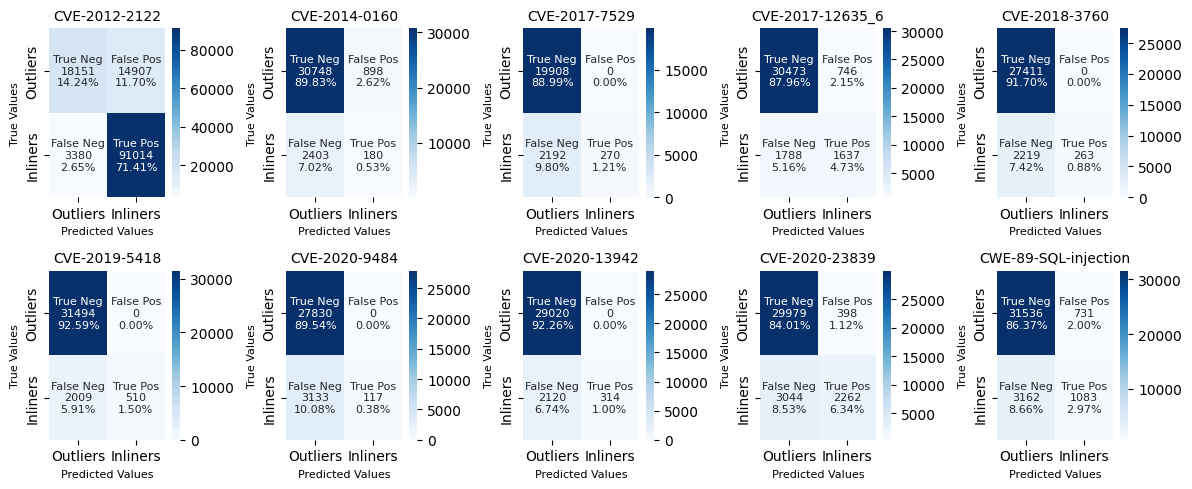

In [33]:
# True Negative: Top Left
# False Postive: Top Right
# False Negative: Bottom Left
# True Positive: Bottom Right

# Confusion Matrices
cms = {}
for key in results.keys():
    C = confusion_matrix(y_true=y_true[key], y_pred=results[key]['VariationalAutoencoder_predictions'])
    # dictionary with scenario name as key and confusion matrix as value
    dict_ = {key:C}
    cms.update(dict_)

fig, axes = plt.subplots(2,5, figsize=(12,5))
# CVE-2012-2122
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2012-2122'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2012-2122'].flatten()/np.sum(cms['CVE-2012-2122'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cms['CVE-2012-2122'], annot=labels,
            annot_kws={"fontsize":8},
            fmt='2', cmap='Blues',
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,0])
axes[0,0].set_title('CVE-2012-2122', size=10)
axes[0,0].set_xlabel('Predicted Values', size=8)
axes[0,0].set_ylabel('True Values', size=8)

#CVE-2014-0160
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2014-0160'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2014-0160'].flatten()/np.sum(cms['CVE-2014-0160'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2014-0160'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,1])
axes[0,1].set_title('CVE-2014-0160', size=10)
axes[0,1].set_xlabel('Predicted Values', size=8)
axes[0,1].set_ylabel('True Values', size=8)


#CVE-2017-7529
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-7529'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-7529'].flatten()/np.sum(cms['CVE-2017-7529'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-7529'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,2])
axes[0,2].set_title('CVE-2017-7529', size=10)
axes[0,2].set_xlabel('Predicted Values', size=8)
axes[0,2].set_ylabel('True Values', size=8)


#CVE-2017-12635_6
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2017-12635_6'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2017-12635_6'].flatten()/np.sum(cms['CVE-2017-12635_6'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2017-12635_6'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,3])
axes[0,3].set_title('CVE-2017-12635_6', size=10)
axes[0,3].set_xlabel('Predicted Values', size=8)
axes[0,3].set_ylabel('True Values', size=8)



#CVE-2018-3760
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2018-3760'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2018-3760'].flatten()/np.sum(cms['CVE-2018-3760'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2018-3760'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[0,4])
axes[0,4].set_title('CVE-2018-3760', size=10)
axes[0,4].set_xlabel('Predicted Values', size=8)
axes[0,4].set_ylabel('True Values', size=8)


#CVE-2019-5418
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2019-5418'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2019-5418'].flatten()/np.sum(cms['CVE-2019-5418'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2019-5418'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,0])
axes[1,0].set_title('CVE-2019-5418', size=10)
axes[1,0].set_xlabel('Predicted Values', size=8)
axes[1,0].set_ylabel('True Values', size=8)

#CVE-2020-9484
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-9484'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-9484'].flatten()/np.sum(cms['CVE-2020-9484'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-9484'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
             xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,1])
axes[1,1].set_title('CVE-2020-9484', size=10)
axes[1,1].set_xlabel('Predicted Values', size=8)
axes[1,1].set_ylabel('True Values', size=8)


#CVE-2020-13942
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-13942'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-13942'].flatten()/np.sum(cms['CVE-2020-13942'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-13942'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,2])
axes[1,2].set_title('CVE-2020-13942', size=10)
axes[1,2].set_xlabel('Predicted Values', size=8)
axes[1,2].set_ylabel('True Values', size=8)


#CVE-2020-23839
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CVE-2020-23839'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CVE-2020-23839'].flatten()/np.sum(cms['CVE-2020-23839'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CVE-2020-23839'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,3])
axes[1,3].set_title('CVE-2020-23839', size=10)
axes[1,3].set_xlabel('Predicted Values', size=8)
axes[1,3].set_ylabel('True Values', size=8)


#CWE-89-SQL-injection
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cms['CWE-89-SQL-injection'].flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cms['CWE-89-SQL-injection'].flatten()/np.sum(cms['CWE-89-SQL-injection'])]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)


sns.heatmap(cms['CWE-89-SQL-injection'], annot=labels,
            fmt='2', cmap='Blues',
            annot_kws={"fontsize":8},
            xticklabels=["Outliers",'Inliners'], yticklabels=["Outliers", 'Inliners'],
            ax=axes[1,4])
axes[1,4].set_title('CWE-89-SQL-injection', size=10)
axes[1,4].set_xlabel('Predicted Values', size=8)
axes[1,4].set_ylabel('True Values', size=8)


fig.tight_layout()
plt.show()
fig.savefig("../../../src/plots/models/VAE_ConfusionMatrix_contamination_rate_no_outliers.png")

In [34]:
# get rates to evaluate the results
pd.options.display.float_format = '{:.2f}'.format
data = {}
for key in cms.keys():
    true_negative = cms[key][0,0]
    false_positve = cms[key][0,1]
    false_negative = cms[key][1,0]
    true_positve = cms[key][1,1]
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = true_positve/(true_positve+false_negative)
    # Specificity or true negative rate
    TNR = true_negative/(true_negative+false_positve) 
    # Precision or positive predictive value
    PPV = true_positve/(true_positve+false_positve)
    # Negative predictive value
    NPV = true_negative/(true_negative+false_negative)
    # Fall out or false positive rate
    FPR = false_positve/(false_positve+true_negative)
    # False negative rate
    FNR = false_negative/(true_positve+false_negative)
    # False discovery rate
    FDR = false_positve/(true_positve+false_positve)
    # Overall accuracy
    ACC = (true_positve+true_negative)/(true_positve+false_positve+false_negative+true_negative)
    # F1 Score
    F1 =  2 * (PPV * TPR) / (PPV + TPR)

    data[key] = {
        "FPR": FPR,
        "FNR": FNR,
        "Recall": TPR,
        "Precision": PPV,
        "ACC": ACC,
        "F1": F1

    }
# print dataframe
output = pd.DataFrame(data).transpose() 
# False Postive Rate (FPR) good because this means that only 7% of the anomalies detected were in fact, not anomalous at all.
# False Negative Rate (FNR) This means that the system missed only 15% of all anomalies in the data.
output.to_latex("../../../src/tables/VAE_Table_FPR_FNR_ACC_TEST_contamination_rate_no_outliers.tex")

In [35]:
output

,FPR,FNR,Recall,Precision,ACC,F1
CVE-2012-2122,0.45,0.04,0.96,0.86,0.86,0.91
CVE-2014-0160,0.03,0.93,0.07,0.17,0.90,0.10
CVE-2017-7529,0.00,0.89,0.11,1.00,0.90,0.20
CVE-2017-12635_6,0.02,0.52,0.48,0.69,0.93,0.56
CVE-2018-3760,0.00,0.89,0.11,1.00,0.93,0.19
CVE-2019-5418,0.00,0.80,0.20,1.00,0.94,0.34
CVE-2020-9484,0.00,0.96,0.04,1.00,0.90,0.07
CVE-2020-13942,0.00,0.87,0.13,1.00,0.93,0.23
CVE-2020-23839,0.01,0.57,0.43,0.85,0.90,0.57
CWE-89-SQL-injection,0.02,0.74,0.26,0.60,0.89,0.36


## Which data points identify as False Positves and why? 
- Scenario CVE-2012-2122 
- Scenario CVE-2020-9484

In [36]:
# look at the complete data 
for i in range(0, len(scenarios)):
    results[scenarios[i]]['True_Exploit'] = y_true[scenarios[i]]

In [37]:
fp_CVE_2012_2122 = results['CVE-2012-2122'][(results['CVE-2012-2122']['True_Exploit']==0)&(results['CVE-2012-2122']['IsolationForest_predictions']==1)] 
tp_CVE_2012_2122 = results['CVE-2012-2122'][(results['CVE-2012-2122']['True_Exploit']==1)&(results['CVE-2012-2122']['IsolationForest_predictions']==1)] 
fp_CVE_2020_9484 = results['CVE-2020-9484'][(results['CVE-2020-9484']['True_Exploit']==0)&(results['CVE-2020-9484']['IsolationForest_predictions']==1)] 
tp_CVE_2020_9484 = results['CVE-2020-9484'][(results['CVE-2020-9484']['True_Exploit']==1)&(results['CVE-2020-9484']['IsolationForest_predictions']==1)] 

,cpu_usage,memory_usage,VariationalAutoencoder_predictions,VariationalAutoencoder_scores,True_Exploit
timestamp,,,,,
2021-10-12 18:05:27.973,3.05,162144256,0,0.81,0
2021-10-12 18:05:28.976,2.09,162213888,0,0.54,0
2021-10-12 18:05:29.980,4.10,162455552,0,1.45,0
2021-10-12 18:05:30.984,2.85,166162432,0,0.52,0
2021-10-12 18:05:31.988,2.41,169709568,0,0.14,0
...,...,...,...,...,...
2021-09-10 14:45:07.744,4.29,165371904,0,1.52,1
2021-09-10 14:45:08.749,3.51,165773312,0,0.97,1
2021-09-10 14:45:09.753,1.28,167157760,0,0.70,1
